In [12]:
import re
import torch
import detector
import graphviz
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, tree, neighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

LANGS = ['en', 'es', 'fr', 'de']
BLEU_HEURISTIC = {'de_en': 0.334, 'de_es': 0.305, 'de_fr': 0.312, 'en_de': 0.269, 'en_es': 0.389, 'en_fr': 0.370, 'es_de': 0.248, 'es_en': 0.395, 'es_fr': 0.354, 'fr_de': 0.237, 'fr_en': 0.356, 'fr_es': 0.337}

In [13]:
data = pd.read_csv('data/bleu_table_se_extended.csv', index_col=0)
data['src'] = data['src'].astype('category')
data['origin'] = data['origin'].astype('category')

In [14]:
data

,T0-T1_en,T1-T2_en,T0-T1_es,T1-T2_es,T0-T1_fr,T1-T2_fr,T0-T1_de,T1-T2_de,src,origin,len
0,0.947723,1.000000,0.922872,1.000000,0.0,0.0,0.888121,1.000000,fr,en,141.0
1,0.855590,1.000000,0.872833,0.976575,0.0,0.0,0.709730,0.878135,fr,en,137.0
2,0.952221,1.000000,0.860168,1.000000,0.0,0.0,0.666143,0.908386,fr,en,121.0
3,0.874620,0.968247,0.820390,0.931801,0.0,0.0,0.614086,0.914396,fr,en,117.0
4,0.861594,0.898524,0.949721,0.924916,0.0,0.0,0.812970,0.869073,fr,en,121.0
...,...,...,...,...,...,...,...,...,...,...,...
29065,0.730762,0.958664,0.713979,0.825344,0.0,0.0,0.665398,0.824020,fr,de,121.0
29066,0.813644,0.969884,0.694211,0.971297,0.0,0.0,0.651790,1.000000,fr,de,135.0
29067,0.909051,0.977297,0.964304,1.000000,0.0,0.0,0.532420,0.901480,fr,de,133.0
29068,0.898386,0.955865,0.869360,0.977216,0.0,0.0,0.815371,0.906313,fr,de,138.0


## Utility functions

In [165]:
def plot_confusion_matrix(true_labels, prediction, column_labels): 
    cm_data = confusion_matrix(true_labels, prediction)
    df_cm = pd.DataFrame(cm_data, columns=column_labels, index = column_labels)
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (10,7))
    sn.set(font_scale=1.4)
    sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})

def correct_by_lang_pair(table, pred, true):
    pred_data = table.copy()[['src']]
    pred_data['origin'] = true
    pred_data['src'] = pred_data['src'].apply(lambda x: int(x * 4) if x < 1 else int(x * 4) - 1)
    pred_data['pred'] = pred
    pred_data['right_pred'] = pred_data.apply(lambda x: x['origin'] == x['pred'], axis=1)
    correct = pred_data[pred_data['right_pred'] == True]
    correct = correct.groupby(['src', 'pred']).count()
    correct = correct[['right_pred']]
    correct['bleu'] = [BLEU_HEURISTIC["{}_{}".format(LANGS[x[0]], LANGS[x[1]])] for x in correct.index]
    # correct['bleu'] = normalize_values(correct['bleu'].values.reshape(-1, 1))
    return correct

## Filter problematic rows and columns

In [16]:
def non_equal_row(row):
    non_src_langs = [lang for lang in LANGS if lang != row['src']]
    unique_values = set([row['T0-T1_'+lang] for lang in non_src_langs] + [row['T1-T2_'+lang] for lang in non_src_langs])
    return len(unique_values) > 1

filtered = data[(data.len > 10) & (data.apply(non_equal_row, axis=1))]
filtered = filtered.reset_index(drop=True)
# filtered = filtered.drop(columns=['T2-T3_en', 'T2-T3_es', 'T2-T3_fr', 'T2-T3_de'])

In [17]:
filtered

,T0-T1_en,T1-T2_en,T0-T1_es,T1-T2_es,T0-T1_fr,T1-T2_fr,T0-T1_de,T1-T2_de,src,origin,len
0,0.947723,1.000000,0.922872,1.000000,0.0,0.0,0.888121,1.000000,fr,en,141.0
1,0.855590,1.000000,0.872833,0.976575,0.0,0.0,0.709730,0.878135,fr,en,137.0
2,0.952221,1.000000,0.860168,1.000000,0.0,0.0,0.666143,0.908386,fr,en,121.0
3,0.874620,0.968247,0.820390,0.931801,0.0,0.0,0.614086,0.914396,fr,en,117.0
4,0.861594,0.898524,0.949721,0.924916,0.0,0.0,0.812970,0.869073,fr,en,121.0
...,...,...,...,...,...,...,...,...,...,...,...
29061,0.800260,0.937822,0.938863,0.980116,0.0,0.0,0.696506,0.940081,fr,de,149.0
29062,0.730762,0.958664,0.713979,0.825344,0.0,0.0,0.665398,0.824020,fr,de,121.0
29063,0.813644,0.969884,0.694211,0.971297,0.0,0.0,0.651790,1.000000,fr,de,135.0
29064,0.909051,0.977297,0.964304,1.000000,0.0,0.0,0.532420,0.901480,fr,de,133.0


## Remove divergent rows

In [18]:
convergent = []
for lang in LANGS:
    convergent.append(filtered[(filtered['T0-T1_{}'.format(lang)] <= filtered['T1-T2_{}'.format(lang)]) & (filtered['origin'] == lang)])

filtered = pd.concat(convergent, axis=0)
filtered = filtered.reset_index(drop=True)
filtered

,T0-T1_en,T1-T2_en,T0-T1_es,T1-T2_es,T0-T1_fr,T1-T2_fr,T0-T1_de,T1-T2_de,src,origin,len
0,0.947723,1.000000,0.922872,1.000000,0.0,0.0,0.888121,1.000000,fr,en,141.0
1,0.855590,1.000000,0.872833,0.976575,0.0,0.0,0.709730,0.878135,fr,en,137.0
2,0.952221,1.000000,0.860168,1.000000,0.0,0.0,0.666143,0.908386,fr,en,121.0
3,0.874620,0.968247,0.820390,0.931801,0.0,0.0,0.614086,0.914396,fr,en,117.0
4,0.861594,0.898524,0.949721,0.924916,0.0,0.0,0.812970,0.869073,fr,en,121.0
...,...,...,...,...,...,...,...,...,...,...,...
27127,0.800260,0.937822,0.938863,0.980116,0.0,0.0,0.696506,0.940081,fr,de,149.0
27128,0.730762,0.958664,0.713979,0.825344,0.0,0.0,0.665398,0.824020,fr,de,121.0
27129,0.813644,0.969884,0.694211,0.971297,0.0,0.0,0.651790,1.000000,fr,de,135.0
27130,0.909051,0.977297,0.964304,1.000000,0.0,0.0,0.532420,0.901480,fr,de,133.0


## Generate Diffs Table

In [19]:
def translation_bias(src, lang, bias = 0):
    # if src == 'en' and lang == 'de' or src == 'de' and lang == 'en' or src == 'es' and lang == 'fr' or src == 'fr' and lang == 'es':
    if src != lang:
        return BLEU_HEURISTIC["{}_{}".format(src, lang)] * bias
    return 0

diffs = []
for lang in LANGS:
    first_col = 'T0-T1_{}'.format(lang)
    second_col = 'T1-T2_{}'.format(lang)
    diffs.append(filtered[[first_col, second_col, 'src']].apply(lambda x: ((1 - (x[second_col] + translation_bias(x['src'], lang))) + (1 - (x[first_col] + translation_bias(x['src'], lang)))), axis=1))

diff_df = pd.concat(diffs + [filtered[['origin', 'src']]], axis=1)
diff_df.columns = ['en_diff', 'es_diff', 'fr_diff', 'de_diff','origin', 'src']

In [10]:
diff_df

,en_diff,es_diff,fr_diff,de_diff,origin,src
0,0.052277,0.077128,2.0,0.111879,en,fr
1,0.144410,0.150592,2.0,0.412135,en,fr
2,0.047779,0.139832,2.0,0.425470,en,fr
3,0.157133,0.247809,2.0,0.471517,en,fr
4,0.239882,0.125363,2.0,0.317957,en,fr
...,...,...,...,...,...,...
29061,0.261917,0.081021,2.0,0.363413,de,fr
29062,0.310574,0.460677,2.0,0.510582,de,fr
29063,0.216472,0.334491,2.0,0.348210,de,fr
29064,0.113652,0.035696,2.0,0.566100,de,fr


## A little bit of exploration

In [20]:
diff_ratios = []
for lang in LANGS:
    lang_col = '{}_diff'.format(lang)
    other_langs = ['{}_diff'.format(l) for l in LANGS if l != lang]
    diff_ratios.append(len(diff_df[(diff_df[lang_col] < diff_df[other_langs[0]]) & (diff_df[lang_col] < diff_df[other_langs[1]]) & (diff_df[lang_col] < diff_df[other_langs[2]]) & (diff_df['origin'] == lang)]) / len(diff_df[(diff_df['origin'] == lang)]))

diff_ratios

[0.5614220877458397,
 0.5115010321439104,
 0.40755278830536007,
 0.11067380352644836]

In [21]:
def convergence_ratio(df, l_cols, r_cols, origins):
    for lcol, rcol, orig in zip(l_cols, r_cols, origins):
        ratio = len(df[(df[lcol] <= df[rcol]) & (df['origin'] == orig)]) / len(df[(df['origin'] == orig)])
        print("Ratio for {} < {} and origin {}: {}".format(lcol, rcol, orig, ratio))

In [100]:
convergence_ratio(filtered, ['T0-T1_' + lang for lang in LANGS], ['T1-T2_' + lang for lang in LANGS], LANGS)

Ratio for T0-T1_en < T1-T2_en and origin en: 1.0
Ratio for T0-T1_es < T1-T2_es and origin es: 1.0
Ratio for T0-T1_fr < T1-T2_fr and origin fr: 1.0
Ratio for T0-T1_de < T1-T2_de and origin de: 1.0


## Normalize Data

In [22]:
def normalize_values(values):
    scaler = MinMaxScaler()
    return scaler.fit_transform(values)

norm_data = filtered.copy()

norm_data['len'] = normalize_values(norm_data['len'].values.reshape(-1, 1))
norm_data['src'] = normalize_values(norm_data['src'].cat.codes.values.reshape(-1, 1))
norm_data['origin'] = norm_data['origin'].cat.codes.values.reshape(-1, 1)

norm_data

,T0-T1_en,T1-T2_en,T0-T1_es,T1-T2_es,T0-T1_fr,T1-T2_fr,T0-T1_de,T1-T2_de,src,origin,len
0,0.947723,1.000000,0.922872,1.000000,0.0,0.0,0.888121,1.000000,1.0,1,0.573991
1,0.855590,1.000000,0.872833,0.976575,0.0,0.0,0.709730,0.878135,1.0,1,0.556054
2,0.952221,1.000000,0.860168,1.000000,0.0,0.0,0.666143,0.908386,1.0,1,0.484305
3,0.874620,0.968247,0.820390,0.931801,0.0,0.0,0.614086,0.914396,1.0,1,0.466368
4,0.861594,0.898524,0.949721,0.924916,0.0,0.0,0.812970,0.869073,1.0,1,0.484305
...,...,...,...,...,...,...,...,...,...,...,...
27127,0.800260,0.937822,0.938863,0.980116,0.0,0.0,0.696506,0.940081,1.0,0,0.609865
27128,0.730762,0.958664,0.713979,0.825344,0.0,0.0,0.665398,0.824020,1.0,0,0.484305
27129,0.813644,0.969884,0.694211,0.971297,0.0,0.0,0.651790,1.000000,1.0,0,0.547085
27130,0.909051,0.977297,0.964304,1.000000,0.0,0.0,0.532420,0.901480,1.0,0,0.538117


## Training: Neural Network

In [197]:
dummy_y = [0] * len(norm_data.index)
X_train, X_test, y_train, y_test = train_test_split(norm_data, dummy_y, test_size=0.20, random_state=42)
X_train

,T0-T1_en,T1-T2_en,T0-T1_es,T1-T2_es,T0-T1_fr,T1-T2_fr,T0-T1_de,T1-T2_de,src,origin,len
6340,0.774040,1.000000,0.785280,0.907442,0.621929,0.836881,0.000000,0.000000,0.000000,1,0.349776
14947,0.000000,0.000000,0.973607,1.000000,0.901247,0.966961,0.813933,0.947837,0.333333,3,0.349776
2165,0.787287,0.924577,0.817479,0.956764,0.000000,0.000000,0.726117,0.869276,1.000000,1,0.515695
26659,0.923018,0.957578,0.828726,0.844232,0.000000,0.000000,0.616965,0.715356,1.000000,0,0.614350
23267,0.000000,0.000000,0.885518,0.966162,0.793185,0.957845,0.712027,0.845441,0.333333,0,0.524664
...,...,...,...,...,...,...,...,...,...,...,...
21575,0.880415,0.913372,0.000000,0.000000,0.775064,0.941995,0.701569,0.830910,0.666667,0,0.618834
5390,0.751892,1.000000,0.897888,0.938529,0.649301,0.787807,0.000000,0.000000,0.000000,1,0.367713
860,0.715115,0.942242,0.757928,0.887725,0.000000,0.000000,0.601766,0.756848,1.000000,1,0.426009
15795,0.000000,0.000000,0.838167,0.895265,0.794312,0.866804,0.652380,0.804852,0.333333,3,0.475336


In [198]:
dataset = detector.BLEUDataset(X_train)
loader = detector.DataLoader(dataset, batch_size=1000, shuffle=False, num_workers=4)
network = detector.Classifier()
network.load_state_dict(torch.load('models/classifier_3k_v2_2000.pth'))
network.float()
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
network.to(device)

Classifier(
  (hidden0): Linear(in_features=10, out_features=1024, bias=True)
  (hidden1): Linear(in_features=1024, out_features=512, bias=True)
  (hidden2): Linear(in_features=512, out_features=128, bias=True)
  (hidden3): Linear(in_features=128, out_features=32, bias=True)
  (hidden4): Linear(in_features=32, out_features=8, bias=True)
  (out): Linear(in_features=8, out_features=4, bias=True)
  (l_relu): LeakyReLU(negative_slope=0.01)
  (softmax): Softmax(dim=1)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [114]:
detector.train_classifier(network, loader, 2000, 20, device)

7150% accuracy
Epoch 1740 took: 2.675s
Epoch 1741, iter 20: 1.1954 loss | 53.9300% accuracy
Epoch 1741 took: 2.370s
Epoch 1742, iter 20: 1.1983 loss | 53.3750% accuracy
Epoch 1742 took: 2.451s
Epoch 1743, iter 20: 1.2096 loss | 52.2950% accuracy
Epoch 1743 took: 2.311s
Epoch 1744, iter 20: 1.2060 loss | 52.8400% accuracy
Epoch 1744 took: 2.621s
Epoch 1745, iter 20: 1.1969 loss | 53.6100% accuracy
Epoch 1745 took: 2.671s
Epoch 1746, iter 20: 1.1954 loss | 53.8650% accuracy
Epoch 1746 took: 2.637s
Epoch 1747, iter 20: 1.2012 loss | 53.1250% accuracy
Epoch 1747 took: 2.649s
Epoch 1748, iter 20: 1.1937 loss | 54.1900% accuracy
Epoch 1748 took: 2.685s
Epoch 1749, iter 20: 1.1938 loss | 54.1600% accuracy
Epoch 1749 took: 2.407s
Epoch 1750, iter 20: 1.2049 loss | 52.7650% accuracy
Epoch 1750 took: 2.472s
Epoch 1751, iter 20: 1.2100 loss | 52.3250% accuracy
Epoch 1751 took: 2.401s
Epoch 1752, iter 20: 1.2020 loss | 53.0500% accuracy
Epoch 1752 took: 2.444s
Epoch 1753, iter 20: 1.1981 loss | 53

In [115]:
torch.save(network.state_dict(), 'models/classifier_3k_v2_4000.pth')

## Testing the NN

In [199]:
dataset = detector.BLEUDataset(X_test)
loader = detector.DataLoader(dataset, batch_size=1000, shuffle=False, num_workers=4)
network = detector.Classifier()
network.load_state_dict(torch.load('models/classifier_3k_v2_4000.pth'))
network.float()

Classifier(
  (hidden0): Linear(in_features=10, out_features=1024, bias=True)
  (hidden1): Linear(in_features=1024, out_features=512, bias=True)
  (hidden2): Linear(in_features=512, out_features=128, bias=True)
  (hidden3): Linear(in_features=128, out_features=32, bias=True)
  (hidden4): Linear(in_features=32, out_features=8, bias=True)
  (out): Linear(in_features=8, out_features=4, bias=True)
  (l_relu): LeakyReLU(negative_slope=0.01)
  (softmax): Softmax(dim=1)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [200]:
pred = detector.test_classifier(network, loader)

Accuracy of the network on the test data: 50.49%


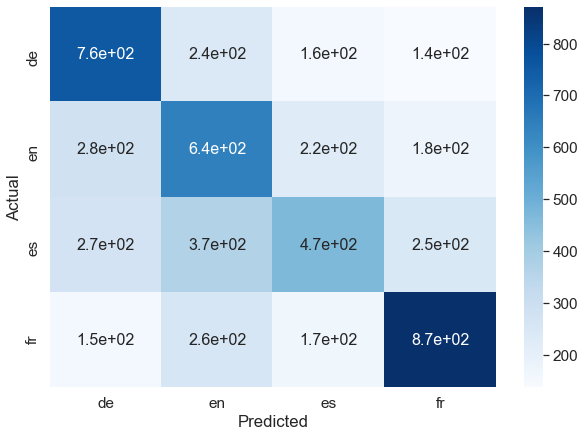

In [201]:
cols = filtered['origin'].cat.categories.values
plot_confusion_matrix(dataset.get_all_labels(), pred, cols)

In [202]:
correct = correct_by_lang_pair(X_test, pred, X_test['origin'])
correct.corr()

,right_pred,bleu
right_pred,1.000000,-0.284314
bleu,-0.284314,1.000000


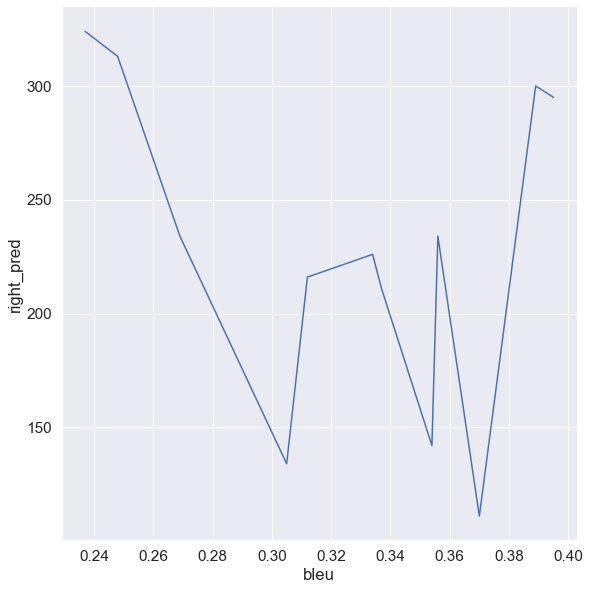

In [203]:
sn.relplot(x='bleu', y='right_pred', data=correct, kind='line', height=8.5)

## Training: Support Vector Machine

In [191]:
y = norm_data['origin']
X = norm_data.loc[:, norm_data.columns != 'origin']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train

,T0-T1_en,T1-T2_en,T0-T1_es,T1-T2_es,T0-T1_fr,T1-T2_fr,T0-T1_de,T1-T2_de,src,len
6340,0.774040,1.000000,0.785280,0.907442,0.621929,0.836881,0.000000,0.000000,0.000000,0.349776
14947,0.000000,0.000000,0.973607,1.000000,0.901247,0.966961,0.813933,0.947837,0.333333,0.349776
2165,0.787287,0.924577,0.817479,0.956764,0.000000,0.000000,0.726117,0.869276,1.000000,0.515695
26659,0.923018,0.957578,0.828726,0.844232,0.000000,0.000000,0.616965,0.715356,1.000000,0.614350
23267,0.000000,0.000000,0.885518,0.966162,0.793185,0.957845,0.712027,0.845441,0.333333,0.524664
...,...,...,...,...,...,...,...,...,...,...
21575,0.880415,0.913372,0.000000,0.000000,0.775064,0.941995,0.701569,0.830910,0.666667,0.618834
5390,0.751892,1.000000,0.897888,0.938529,0.649301,0.787807,0.000000,0.000000,0.000000,0.367713
860,0.715115,0.942242,0.757928,0.887725,0.000000,0.000000,0.601766,0.756848,1.000000,0.426009
15795,0.000000,0.000000,0.838167,0.895265,0.794312,0.866804,0.652380,0.804852,0.333333,0.475336


In [192]:
classifier = svm.SVC(probability=True, kernel='poly', C=3.0, gamma='scale')
classifier.fit(X_train, y_train)

SVC(C=3.0, kernel='poly', probability=True)

In [193]:
classifier.score(X_test, y_test)

0.5010134512622075

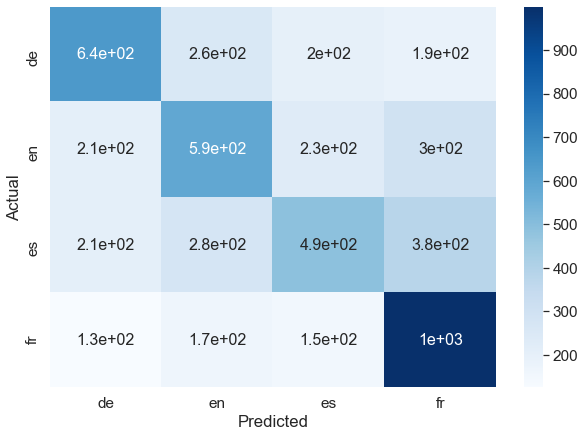

In [194]:
pred = classifier.predict(X_test)
plot_confusion_matrix(y_test.values, pred, filtered['origin'].cat.categories.values)

In [195]:
correct = correct_by_lang_pair(X_test, pred, y_test)
correct.corr()

,right_pred,bleu
right_pred,1.000000,-0.727412
bleu,-0.727412,1.000000


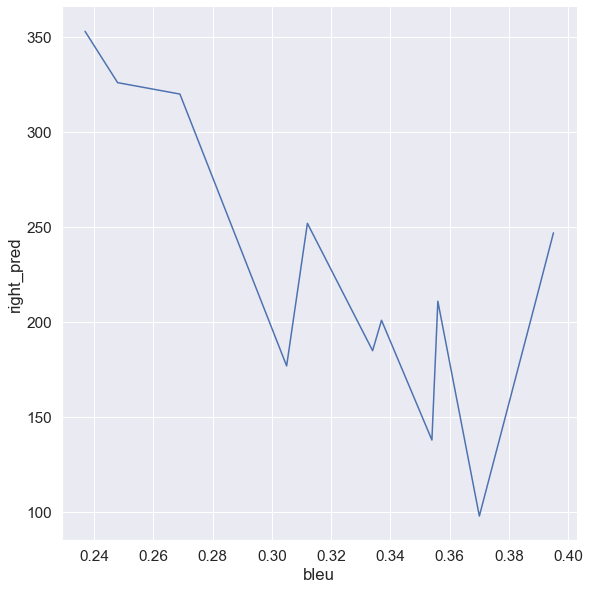

In [196]:
sn.relplot(x='bleu', y='right_pred', data=correct, kind='line', height=8.5)

## Training: Decision Tree

In [186]:
classifier = tree.DecisionTreeClassifier(criterion='entropy')
classifier.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

In [187]:
classifier.score(X_test, y_test)

0.41883176709047354

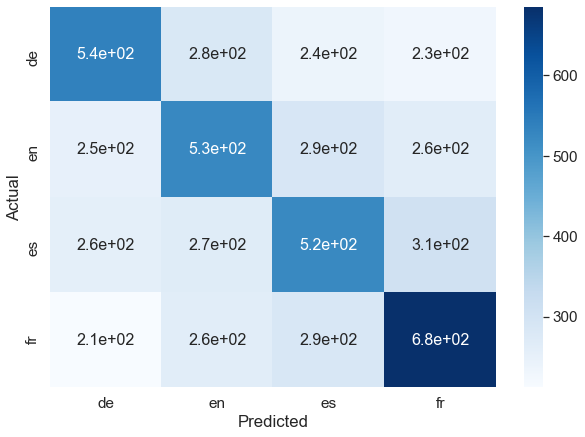

In [188]:
pred = classifier.predict(X_test)
plot_confusion_matrix(y_test.values, pred, filtered['origin'].cat.categories.values)

In [189]:
correct = correct_by_lang_pair(X_test, pred, y_test)
correct.corr()

,right_pred,bleu
right_pred,1.000000,-0.805699
bleu,-0.805699,1.000000


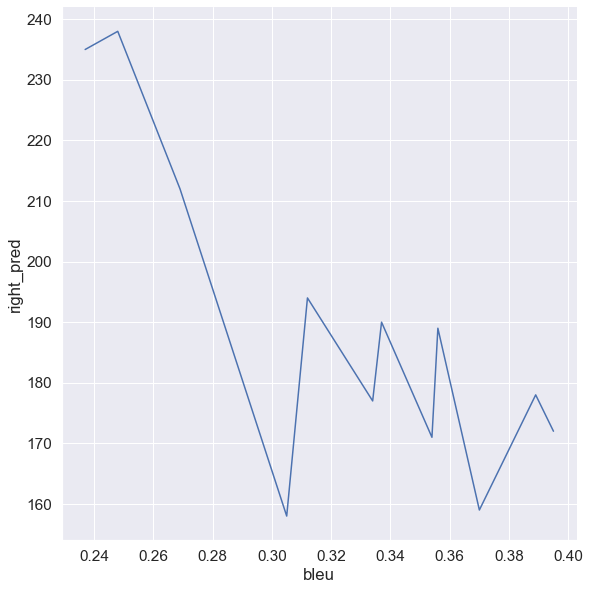

In [190]:
sn.relplot(x='bleu', y='right_pred', data=correct, kind='line', height=8.5)

In [34]:
#dot_data = tree.export_graphviz(classifier, out_file=None)
#graph = graphviz.Source(dot_data)
#graph.render("Tree")

## Training: KNN

In [174]:
classifier = neighbors.KNeighborsClassifier(n_neighbors=141)
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=200)

In [175]:
classifier.score(X_test, y_test)

0.49935507646950433

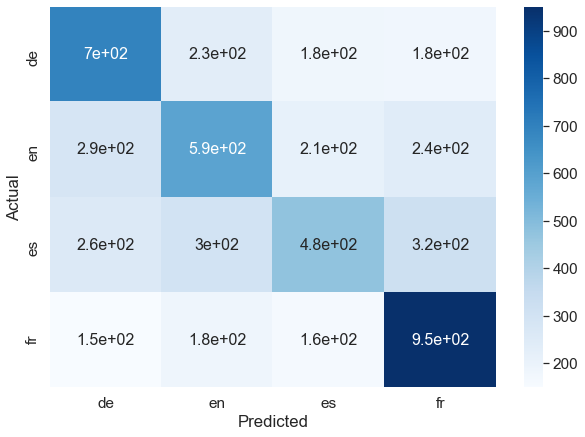

In [176]:
pred = classifier.predict(X_test)
plot_confusion_matrix(y_test.values, pred, filtered['origin'].cat.categories.values)

In [177]:
correct = correct_by_lang_pair(X_test, pred, y_test)
correct.corr()

,right_pred,bleu
right_pred,1.000000,-0.594748
bleu,-0.594748,1.000000


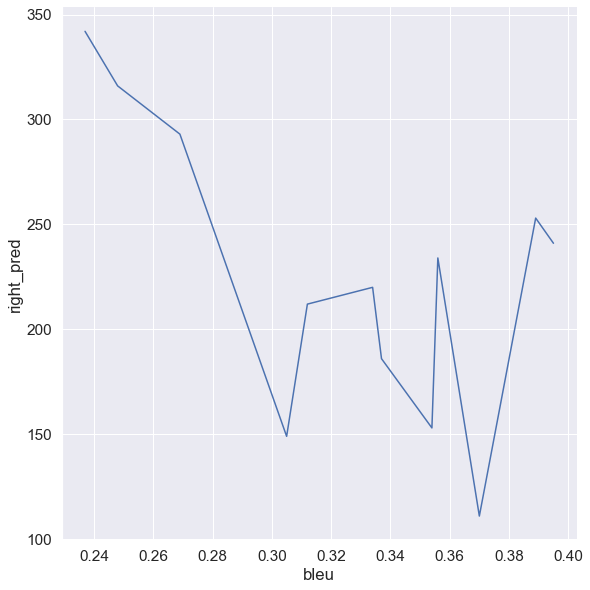

In [181]:
sn.relplot(x='bleu', y='right_pred', data=correct, kind='line', height=8.5)